In [15]:
#!/usr/bin/env python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from os import sys
#from pytorchtools import EarlyStopping

In [16]:
if torch.cuda.is_available():
    torch.cuda.get_device_name(0)
else:
    print("no GPU")

no GPU


In [17]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(270),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [18]:
data_dir = '/home/fasal/projects/Github/Rice plant disease detection using deep learning/dataset'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


In [19]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

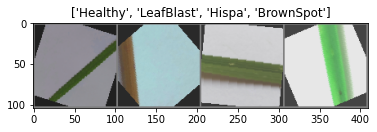

In [20]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc)) 
          
          # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())    


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    # load the last checkpoint with the best model
    #model.load_state_dict(torch.load('checkpoint.pt'))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Training all the layers with some fine tuning with new last layer

In [26]:
#model = models.resnet50(pretrained=True)
model = models.resnet101(weights='ResNet101_Weights.DEFAULT')
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [27]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [28]:
# from torch.optim import Adam
# optimizer = Adam(model.parameters(), lr=0.001)

In [29]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

output_model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.3802 Acc: 0.2799
val Loss: 1.3899 Acc: 0.2422
Epoch 1/9
----------
train Loss: 1.3616 Acc: 0.3380
val Loss: 1.3849 Acc: 0.2733
Epoch 2/9
----------
train Loss: 1.3426 Acc: 0.3488
val Loss: 1.3840 Acc: 0.2671
Epoch 3/9
----------
train Loss: 1.3267 Acc: 0.3962
val Loss: 1.3526 Acc: 0.2733
Epoch 4/9
----------
train Loss: 1.2996 Acc: 0.4169
val Loss: 1.3585 Acc: 0.1925
Epoch 5/9
----------
train Loss: 1.2842 Acc: 0.4186
val Loss: 1.3901 Acc: 0.2609
Epoch 6/9
----------
train Loss: 1.2788 Acc: 0.3987
val Loss: 1.3646 Acc: 0.2857
Epoch 7/9
----------
train Loss: 1.2544 Acc: 0.4269
val Loss: 1.3596 Acc: 0.2857
Epoch 8/9
----------
train Loss: 1.2466 Acc: 0.4452
val Loss: 1.3719 Acc: 0.2857
Epoch 9/9
----------
train Loss: 1.2389 Acc: 0.4477
val Loss: 1.3932 Acc: 0.2981
Training complete in 33m 5s
Best val Acc: 0.298137


In [30]:
torch.save(model, 'adam_res101_4image.pth')

In [31]:
import torch
best_model = torch.load('adam_res101_4image.pth',map_location=torch.device('cpu'))

logits tensor([[-0.4846,  0.1241,  0.4734,  0.3901]])
exponen tensor([[0.6159, 1.1322, 1.6055, 1.4771]])
indices tensor(2)
tensor(2)


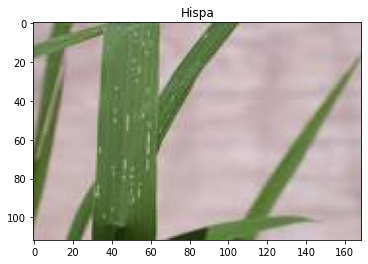

In [34]:
from PIL import *
imsize = 100
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image):
    """load image, returns cuda tensor"""    
    image = loader(image).float()
    image = image.unsqueeze(0) 
    return image

img = Image.open('download.jpeg') 
image = image_loader(img)
    
with torch.no_grad():
    logits = best_model.forward(image)

print('logits',logits)
ps = torch.exp(logits)
_, predTest = torch.max(ps,1)
indices = torch.argmax(logits)
print('exponen',ps) 
print('indices',indices)
print(predTest[0])

class_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

for i in range(len(class_names)):    
    if predTest[0] == i:
        label = class_names[i]

plt.imshow(img)
plt.title(label)
plt.show()